Alignment checking and EDA

Cell 0 — Init, env, add src/ to path, locate RVTALL

In [7]:
# Colab Starter — Set base, validate data, and run lightweight EDA

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

'''
def add_src_to_sys_path(start: Path | None = None) -> Path:
    """Find the nearest folder containing 'src' and add it to sys.path."""
    here = Path(start or Path.cwd()).resolve()
    for parent in (here, *here.parents):
        src = parent / "src"
        if src.is_dir():
            if str(src) not in sys.path:
                sys.path.insert(0, str(src))
            print("✅ Added to sys.path:", src)
            return src
    raise FileNotFoundError("Could not find a 'src' directory above this notebook.")

SRC_DIR = add_src_to_sys_path()
'''

def add_project_root_to_sys_path(start: Path | None = None) -> Path:
    """Find the nearest parent folder containing a `src` directory and add it to sys.path."""
    here = Path(start or Path.cwd()).resolve()
    for parent in (here, *here.parents):
        if (parent / 'src').is_dir():
            if str(parent) not in sys.path:
                sys.path.insert(0, str(parent))
                print(f"✅ Added to sys.path: {parent}")
            return parent
    raise FileNotFoundError("Could not find a parent directory containing a `src` directory above this notebook.")

PROJECT_ROOT = add_project_root_to_sys_path()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Added to sys.path: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal


Cell 1 — Imports, base discovery, quick counts

In [9]:
import os, math, random, warnings, json
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.io import wavfile, loadmat

from src.utils.rvtall_io import (
    find_rvtall_base, list_sets, list_corpora_dirs, corpus_type,
    resolve_corpus_dir, kinect_pair_index_paths, kinect_first_pair,
    load_audio_env, load_lip_aperture_csv, first_npy, load_npy, zscore
)

from src.scripts.validate_rvtall import (
    summarize, list_unexpected_files
)

# Set seeds, print options, suppress warnings
random.seed(123)
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

BASE = find_rvtall_base(Path.cwd())
print("RVTALL base:", BASE)

#just calling summarize from scripts.rvtall_validate to print out summary: 

summarize(BASE)
list_unexpected_files(BASE)

'''
# fast sanity counts (doesn't traverse all frames)
"""Count files quickly using glob patterns. Only accurate for audio wavs, the rest (mouth pngs, radar/uwb/laser are 0)"""
def fast_counts(BASE: Path):
    root = str(BASE)
    audio_wavs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "audios", "audio_proc_*.wav"))) \
                 + len(glob(os.path.join(root, "kinect_processed", "*", "*", "audio_proc_*.wav")))
    mouth_pngs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "videos", "video_*", "mouth", "*.png"))) \
                 + len(glob(os.path.join(root, "kinect_processed", "*", "*", "mouth", "*.png")))
    radar_npys = len(glob(os.path.join(root, "radar_processed", "*", "*", "sample_*.npy")))
    uwb_npys   = len(glob(os.path.join(root, "uwb_processed",   "*", "*", "sample_*.npy")))
    laser_npys = len(glob(os.path.join(root, "laser_processed", "*", "*", "sample_*.npy")))
    return audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys

audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys = fast_counts(BASE)
print(f"audio wavs : {audio_wavs}")
print(f"mouth pngs : {mouth_pngs}")
print(f"radar npy  : {radar_npys}")
print(f"uwb npy    : {uwb_npys}")
print(f"laser npy  : {laser_npys}")
'''



RVTALL base: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data
audio wavs : 5300
mouth pngs : 468617
radar npy  : 4956
uwb npy    : 10538
laser npy  : 5091
[OK] Total files indexed: 494502
[!] 5 unexpected file(s) found (first 10 shown):
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\kinect_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\laser_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\radar_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\uwb_processed.7z
   - C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data\uwb_processed\10\vowel_1.7z


'\n# fast sanity counts (doesn\'t traverse all frames)\n"""Count files quickly using glob patterns. Only accurate for audio wavs, the rest (mouth pngs, radar/uwb/laser are 0)"""\ndef fast_counts(BASE: Path):\n    root = str(BASE)\n    audio_wavs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "audios", "audio_proc_*.wav")))                  + len(glob(os.path.join(root, "kinect_processed", "*", "*", "audio_proc_*.wav")))\n    mouth_pngs = len(glob(os.path.join(root, "kinect_processed", "*", "*", "videos", "video_*", "mouth", "*.png")))                  + len(glob(os.path.join(root, "kinect_processed", "*", "*", "mouth", "*.png")))\n    radar_npys = len(glob(os.path.join(root, "radar_processed", "*", "*", "sample_*.npy")))\n    uwb_npys   = len(glob(os.path.join(root, "uwb_processed",   "*", "*", "sample_*.npy")))\n    laser_npys = len(glob(os.path.join(root, "laser_processed", "*", "*", "sample_*.npy")))\n    return audio_wavs, mouth_pngs, radar_npys, uwb_npys, laser_npys\n

# Cell 2 — Core helpers (lag, resampling, compact feature functions)

- PCA aperture gives you a moving signal even when fixed index columns are wrong.

 -find_lag_bounded prevents “–4.8 s” nonsense by searching only plausible lags and returning peak Pearson r so you can filter unreliable pairs.

In [20]:
def rms_envelope(x, win):
    if win <= 1: return np.abs(x)
    k = np.ones(win)/win
    return np.sqrt(np.convolve(x**2, k, mode="same"))

def resample_to_len(x, L):
    return np.interp(np.linspace(0,1,L), np.linspace(0,1,len(x)), x)

# ---- Landmark loaders & PCA aperture ----

def _load_landmarks_3d_csv(csv_path):
    """
    Returns array [T, P, 3]. Works when CSV columns are flattened [x0,y0,z0,...]
    or named in arbitrary fashion as long as total columns is multiple of 3.
    """
    df = pd.read_csv(csv_path)
    vals = df.values
    C = vals.shape[1]
    if C % 3 != 0:
        # Try a heuristic: keep columns that look like x/y/z triplets
        cols = [c for c in df.columns if c.lower().endswith(('x','y','z'))]
        if cols:
            vals = df[cols].values
            C = vals.shape[1]
    assert C % 3 == 0, f"Cannot parse 3D landmarks from {csv_path} (cols={C})"
    P = C // 3
    L = vals.reshape(len(df), P, 3)
    return L

def lip_aperture_pca(csv_path):
    """
    PCA-based aperture: find direction of maximal motion across time (PC1 on deltas),
    then per frame use spread along that axis (p90 - p10). Robust to rotation & column quirks.
    """
    L = _load_landmarks_3d_csv(csv_path)          # [T,P,3]
    T, P, _ = L.shape
    # center per-point over time, then stack (T*P, 3)
    D = (L - L.mean(axis=0, keepdims=True)).reshape(T*P, 3)
    # PCA via SVD
    U, S, Vt = np.linalg.svd(D, full_matrices=False)
    v = Vt[0]                                     # principal motion direction (3,)
    # per-frame projections and spread
    proj = L @ v                                  # [T,P]
    aperture = np.percentile(proj, 90, axis=1) - np.percentile(proj, 10, axis=1)
    return aperture.astype(float)

def lip_aperture_fallback(csv_path, upper_idx=51, lower_idx=57):
    """Old single-axis depth-based aperture; use only as fallback."""
    df = pd.read_csv(csv_path)
    C = df.shape[1]
    if C % 3 != 0:            # cannot index by fixed ids
        return None
    up = df.iloc[:, upper_idx*3 + 2].to_numpy()
    lo = df.iloc[:, lower_idx*3 + 2].to_numpy()
    return (lo - up).astype(float)

def lip_aperture(csv_path):
    """Try PCA first; if it fails or is flat, fall back to fixed indices."""
    try:
        ap = lip_aperture_pca(csv_path)
        if np.nanstd(ap) < 1e-6:
            fb = lip_aperture_fallback(csv_path)
            return fb if fb is not None else ap
        return ap
    except Exception:
        fb = lip_aperture_fallback(csv_path)
        if fb is None:
            raise
        return fb

# ---- Audio envelope ----

def audio_envelope(wav_path, rms_ms=20):
    from scipy.io import wavfile
    fs, y = wavfile.read(wav_path)
    y = y.astype(float)
    y /= (np.max(np.abs(y)) + 1e-9)
    win = max(1, int(fs * rms_ms/1000.0))
    env = rms_envelope(y, win)
    t = np.arange(len(env)) / fs
    return env, t, fs

# ---- Cross-correlation with bounded lag window ----

def pearson_at_lag(a, b, lag):
    """Pearson r after shifting a relative to b by 'lag' samples (positive => a lags b)."""
    if lag > 0:
        a2, b2 = a[lag:], b[:-lag]
    elif lag < 0:
        a2, b2 = a[:lag], b[-lag:]
    else:
        a2, b2 = a, b
    if len(a2) < max(16, int(0.1*len(a))):
        return np.nan
    a2, b2 = zscore(a2), zscore(b2)
    return float(np.corrcoef(a2, b2)[0,1])

def find_lag_bounded(a, b, fs, max_lag_ms=300):
    """
    Returns (lag_samples, lag_ms, peak_r). Limits search to ±max_lag_ms.
    Avoids edge maxima when signals aren't correlated.
    """
    a, b = zscore(a), zscore(b)
    maxlag = int(fs * max_lag_ms / 1000.0)
    # full xcorr then restrict window
    xc = correlate(a, b, mode='full')
    center = len(b) - 1
    lo, hi = center - maxlag, center + maxlag + 1
    window = xc[lo:hi]
    lags = np.arange(-maxlag, maxlag+1)
    best_idx = int(np.nanargmax(window))
    lag = int(lags[best_idx])
    # compute normalized corr at that lag
    r = pearson_at_lag(a, b, lag)
    return lag, (1000.0 * lag / fs), r

def envelope_like(x, target_len):
    x = np.asarray(x).squeeze().astype(float)
    x = (x - x.mean()) / (x.std() if x.std() > 1e-8 else 1.0)
    return resample_to_len(x, target_len)


Cell 3 — Single sample overlay (Audio vs Lip), optional Laser/Radar
- single-pair overlays + xcorr plots (all modalities)

Resolved word5 → pair index 0
  audio: audio_proc_0.wav
  land : land_proc_0.csv


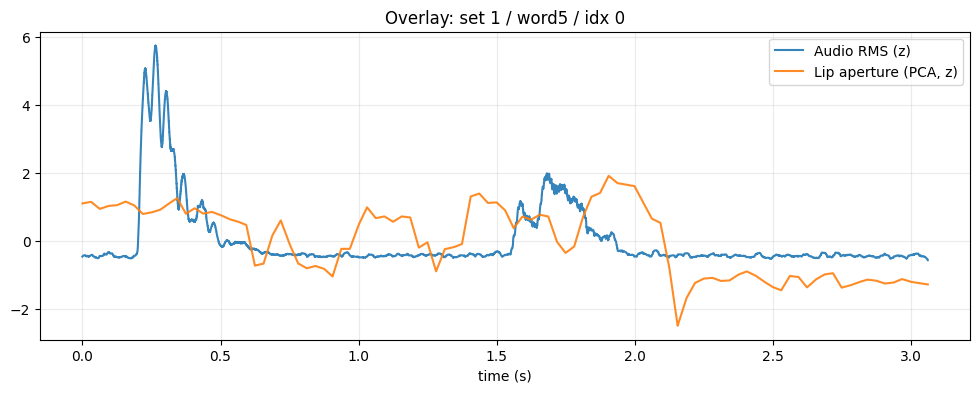

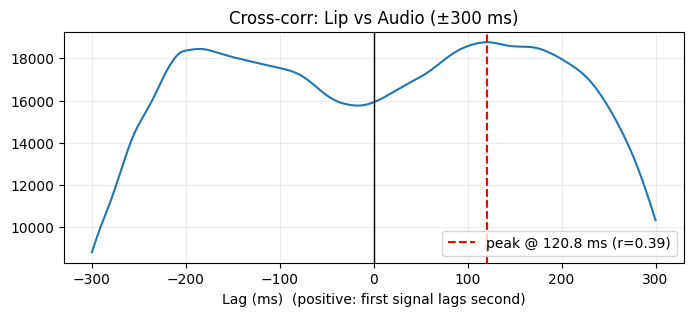

In [21]:
# --- Single sample, rich visualization + cross-corrs ---

set_id = "1"
corpus = "word5"  # can handle 'word_5' / 'sentences1' etc.

cdir = resolve_corpus_dir(BASE, set_id, corpus)
assert cdir is not None, f"Could not resolve corpus dir for {set_id}/{corpus}"

first = kinect_first_pair(BASE, set_id, cdir)
assert first is not None, f"No (audio, landmark) pairs found in {cdir}"
idx, wav_path, csv_path = first
print(f"Resolved {cdir.name} → pair index {idx}\n  audio: {wav_path.name}\n  land : {csv_path.name}")

# Signals
ae, t_audio, fs = audio_envelope(wav_path, rms_ms=20)
lip = lip_aperture(csv_path)
lip = zscore(resample_to_len(lip, len(ae)))

# Optional modalities
laser_p = first_npy(BASE, "laser", set_id, cdir)
radar_p = first_npy(BASE, "radar", set_id, cdir)

laser = zscore(envelope_like(load_npy(laser_p), len(ae))) if laser_p else None
radar = zscore(envelope_like(load_npy(radar_p), len(ae))) if radar_p else None

# Overlays
plt.figure(figsize=(12,4))
plt.plot(t_audio, zscore(ae), label="Audio RMS (z)", alpha=0.9)
plt.plot(t_audio, zscore(lip), label="Lip aperture (PCA, z)", alpha=0.9)
if laser is not None: plt.plot(t_audio, laser, label="Laser (z)", alpha=0.6)
if radar is not None: plt.plot(t_audio, radar, label="Radar (z)", alpha=0.6)
plt.title(f"Overlay: set {set_id} / {cdir.name} / idx {idx}")
plt.xlabel("time (s)"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()

# Cross-correlations (bounded)
def plot_xcorr(a, b, fs, label_a, label_b, max_lag_ms=300):
    lag_samp, lag_ms, r = find_lag_bounded(a, b, fs, max_lag_ms=max_lag_ms)
    # Build the local window for plotting
    maxlag = int(fs * max_lag_ms / 1000.0)
    xc = correlate(zscore(a), zscore(b), mode='full')
    center = len(b) - 1
    lo, hi = center - maxlag, center + maxlag + 1
    window = xc[lo:hi]
    lags = np.arange(-maxlag, maxlag+1) * (1000.0/fs)

    plt.figure(figsize=(8,3))
    plt.plot(lags, window)
    plt.axvline(lag_ms, color='r', ls='--', label=f"peak @ {lag_ms:.1f} ms (r={r:.2f})")
    plt.axvline(0, color='k', lw=1)
    plt.title(f"Cross-corr: {label_a} vs {label_b} (±{max_lag_ms} ms)")
    plt.xlabel("Lag (ms)  (positive: first signal lags second)")
    plt.legend(); plt.grid(True, alpha=0.25); plt.show()
    return lag_ms, r

lag_la_ms, r_la = plot_xcorr(lip, ae, fs, "Lip", "Audio")
if laser is not None:
    lag_laser_ms, r_laser = plot_xcorr(laser, ae, fs, "Laser", "Audio")
if radar is not None:
    lag_radar_ms, r_radar = plot_xcorr(radar, ae, fs, "Radar", "Audio")


Cell 4 — Aggregated sampling (compact stats into DataFrames)

Goals:

don’t sweep the whole dataset; cap per semantic type

build a tidy per-pair table for audio↔lip lags (optionally note presence of laser/radar)

quick summary by semantic type

In [22]:
from collections import defaultdict

def lag_lip_audio_for_pair(wav_path, csv_path, rms_ms=20, max_lag_ms=300):
    ae, _, fs_ = audio_envelope(wav_path, rms_ms)
    la = lip_aperture(csv_path)
    la = resample_to_len(la, len(ae))
    lag_samp, lag_ms, r = find_lag_bounded(la, ae, fs_, max_lag_ms=max_lag_ms)
    return lag_ms, r

def sample_pairs_dataframe(BASE, set_ids=("1","2","3","4"), per_type_cap=30, max_lag_ms=300, r_min=0.15):
    rows, caps = [], defaultdict(int)
    for sid in set_ids:
        for cdir in list_corpora_dirs(BASE, sid):
            sem = corpus_type(cdir.name)
            if sem not in ("vowel","word","sentence"): continue
            if caps[sem] >= per_type_cap: continue

            pairs = kinect_pair_index_paths(cdir)
            if not pairs: continue

            for (idx, wav, csv) in pairs[:3]:
                try:
                    lag_ms, r = lag_lip_audio_for_pair(wav, csv, 20, max_lag_ms)
                except Exception:
                    continue

                # gate on minimum peak correlation
                if np.isnan(r) or r < r_min:
                    continue

                has_laser = first_npy(BASE, "laser", sid, cdir) is not None
                has_radar = first_npy(BASE, "radar", sid, cdir) is not None
                has_uwb   = first_npy(BASE, "uwb",   sid, cdir) is not None

                rows.append({
                    "set_id": sid, "corpus": cdir.name, "semantic": sem,
                    "pair_idx": idx, "lag_lip_to_audio_ms": float(lag_ms),
                    "peak_r": float(r), "has_laser": has_laser,
                    "has_radar": has_radar, "has_uwb": has_uwb
                })
                caps[sem] += 1
                if caps[sem] >= per_type_cap: break
    return pd.DataFrame(rows)

df = sample_pairs_dataframe(BASE, set_ids=tuple(map(str, range(1,5))), per_type_cap=30, max_lag_ms=300, r_min=0.15)
print("rows:", len(df))
display(df.head(10))

summary = (df
    .groupby("semantic")["lag_lip_to_audio_ms"]
    .agg(["count","mean","std","min","max"])
    .reset_index())
print("\nSummary by semantic:")
display(summary)


rows: 90


,set_id,corpus,semantic,pair_idx,lag_lip_to_audio_ms,peak_r,has_laser,has_radar,has_uwb
0,1,sentences1,sentence,1,27.5000,0.221071,False,False,False
1,1,sentences10,sentence,1,-221.5625,0.432795,False,False,False
2,1,sentences10,sentence,2,107.2500,0.292957,False,False,False
3,1,sentences2,sentence,0,-200.5000,0.256352,False,False,False
4,1,sentences2,sentence,1,-130.7500,0.245947,False,False,False
5,1,sentences3,sentence,0,-235.8125,0.238693,False,False,False
6,1,sentences3,sentence,2,224.6250,0.157260,False,False,False
7,1,sentences4,sentence,1,-50.8125,0.165193,False,False,False
8,1,sentences5,sentence,0,-141.8125,0.205489,False,False,False
9,1,sentences5,sentence,1,-224.2500,0.462034,False,False,False



Summary by semantic:


,semantic,count,mean,std,min,max
0,sentence,30,-35.745833,192.343698,-300.0,300.0000
1,vowel,30,12.137500,160.361052,-300.0,290.3125
2,word,30,-52.543750,197.129424,-300.0,300.0000


Cell 5 — Visual summaries (hist, boxplot, alignment score)

Reliable pairs: 90 / 90


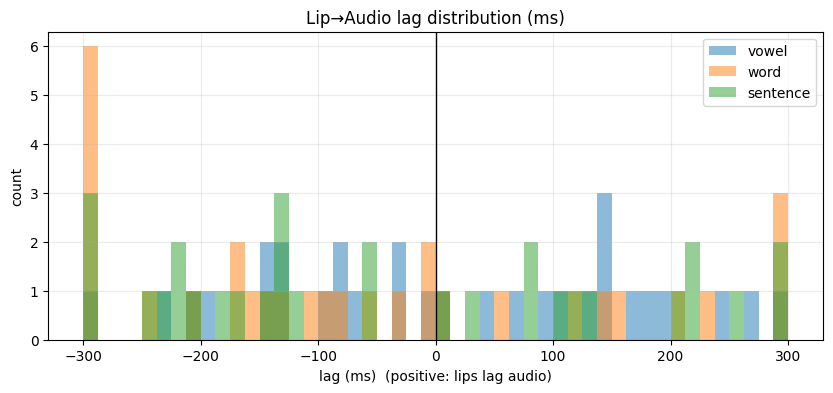

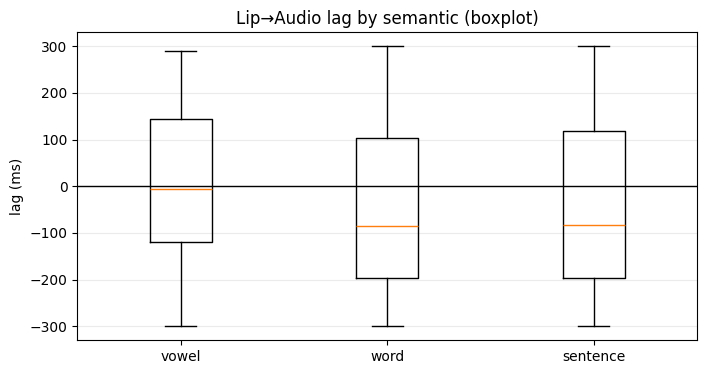

Alignment within ±50 ms: {'vowel': np.float64(16.666666666666664), 'word': np.float64(13.333333333333334), 'sentence': np.float64(6.666666666666667)}
Alignment within ±100 ms: {'vowel': np.float64(36.666666666666664), 'word': np.float64(26.666666666666668), 'sentence': np.float64(20.0)}
Alignment within ±150 ms: {'vowel': np.float64(66.66666666666666), 'word': np.float64(43.333333333333336), 'sentence': np.float64(46.666666666666664)}


In [23]:
# Optional: filter to reliable pairs only
df_rel = df[df.peak_r >= 0.15].copy()
print(f"Reliable pairs: {len(df_rel)} / {len(df)}")

plt.figure(figsize=(10,4))
bins = np.linspace(-300, 300, 49)
for sem in ["vowel","word","sentence"]:
    vals = df_rel.loc[df_rel.semantic==sem, "lag_lip_to_audio_ms"].values
    if len(vals): plt.hist(vals, bins=bins, alpha=0.5, label=sem)
plt.axvline(0, color="k", lw=1)
plt.title("Lip→Audio lag distribution (ms)")
plt.xlabel("lag (ms)  (positive: lips lag audio)"); plt.ylabel("count")
plt.legend(); plt.grid(True, alpha=0.25); plt.show()

data = [df_rel.loc[df_rel.semantic==sem, "lag_lip_to_audio_ms"].values
        for sem in ["vowel","word","sentence"] if (df_rel.semantic==sem).any()]
labels = [sem for sem in ["vowel","word","sentence"] if (df_rel.semantic==sem).any()]
plt.figure(figsize=(8,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.axhline(0, color="k", lw=1)
plt.ylabel("lag (ms)"); plt.title("Lip→Audio lag by semantic (boxplot)")
plt.grid(True, axis="y", alpha=0.25); plt.show()

def alignment_score(df_in, tol_ms=100.0):
    out = {}
    for sem in ["vowel","word","sentence"]:
        sub = df_in[df_in.semantic==sem]["lag_lip_to_audio_ms"].values
        if len(sub):
            pct = 100.0 * np.mean(np.abs(sub) <= tol_ms)
            out[sem] = pct
    return out

print("Alignment within ±50 ms:", alignment_score(df_rel, 50.0))
print("Alignment within ±100 ms:", alignment_score(df_rel, 100.0))
print("Alignment within ±150 ms:", alignment_score(df_rel, 150.0))


Cell 6:Multimodal correlations and lags (including laser/rader) for more quick correlations
- todo: still buggy

In [25]:
# Cross-modal: correlations & lags for audio vs laser/radar on a few rows
def audio_vs_modality(BASE, row, mod, max_rows=10, max_lag_ms=300):
    sid, c = row["set_id"], row["corpus"]
    cdir = resolve_corpus_dir(BASE, sid, c)
    if cdir is None: return None
    first = kinect_first_pair(BASE, sid, cdir)
    if not first: return None
    idx, wav, _ = first
    ae, _, fs = audio_envelope(wav, 20)
    mp = first_npy(BASE, mod, sid, cdir)
    if not mp: return None
    m = envelope_like(load_npy(mp), len(ae))
    lag_samp, lag_ms, r = find_lag_bounded(m, ae, fs, max_lag_ms=max_lag_ms)
    return {"set_id": sid, "corpus": c, "mod": mod, "lag_ms": float(lag_ms), "peak_r": float(r)}

rows = []
for _, r in df_rel.iterrows():
    if r["has_laser"]:
        out = audio_vs_modality(BASE, r, "laser", max_lag_ms=300)
        if out: rows.append(out)
    if r["has_radar"]:
        out = audio_vs_modality(BASE, r, "radar", max_lag_ms=300)
        if out: rows.append(out)
    if len(rows) >= 10: break

df_xm = pd.DataFrame(rows)
print("cross-modal rows:", len(df_xm))
display(df_xm)
df_xm.head()

if len(df_xm):
    print("Mean peak_r by modality:")
    display(df_xm.groupby("mod")["peak_r"].mean().to_frame("mean_corr"))
    df_xm.head()


cross-modal rows: 0


""


Cell 7 — (Optional) Save mean offsets per corpus (light)

(Keeps it small: only for corpora already sampled into df)

In [26]:
df_rel = df[df.peak_r >= 0.15].copy()
offsets = (df_rel.groupby(["set_id","corpus"])["lag_lip_to_audio_ms"]
           .mean().astype(float).to_dict())

print("Offsets saved for", len(offsets), "corpora (reliable only).")
Path("outputs").mkdir(parents=True, exist_ok=True)
np.save("outputs/rvtall_lip_to_audio_offsets_ms.npy", offsets, allow_pickle=True)


Offsets saved for 42 corpora (reliable only).


Cell 8 — (Optional) Training CLI stub (run after you’re happy with alignment)

In [17]:
# When ready to train (from repo root):
# !python -m src.training.train_contrastive --config src/configs/rvtall_contrastive.yaml

Cell 9 — (Optional) Colab compute notes

In [ ]:
# Only if running on Colab:
"""
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!git clone <HTTPS goes here>
%cd silentSpeech 
%pip install -r requirements.txt

# If your RVTALL lives in Drive:
# BASE = Path('/content/drive/MyDrive/RVTALL/Processed_cut_data')
"""
